RSNA Pneumonia Detection Challenge
==
This is the ML project for the Kaggle competition: RSNA Pneumonia Detection Challenge
Transfer learning approch with the Mask-RCNN model and pretrained weights from COCO dataset is used.
Mask-RCNN Starter Model for the RSNA Pneumonia Detection Challenge with transfer learning

The Mask-RCNN packages used here is developed by Waleed Abdulla and can be downloaded here:
https://github.com/matterport/Mask_RCNN
The pre-trained COCO weights can also be downloaded from the link provided in that Github.

This Mask RCNN package needs Python 3.4, TensorFlow 1.3 (<2.0), Keras 2.0.8. Therefore, we check the version of  Python, Tensorflow, and Keras first.

This project must be run in the GPU environment. The CPU environment could not handle this project according to my personal experience...... If your hardware doesn't support CUDA (and tensorflow-gpu), I highly recommend AWS GPU instance.

In [2]:
import tensorflow as tf
import keras
import os

In [3]:
#check the python, keras and the tensorflow version.
print(os.sys.version)
print(keras.__version__)
print(tf.__version__)

3.6.10 |Anaconda, Inc.| (default, Mar 25 2020, 23:51:54) 
[GCC 7.3.0]
2.3.1
1.15.2


In [1]:
import pandas as pd 
import math
import numpy as np
import random 
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import imgaug
import glob
from cv2 import cv2
import pydicom
import matplotlib.patches as patches
import kaggle
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log
import tensorflow as tf
import keras


Bad key "text.kerning_factor" on line 4 in
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


Using TensorFlow backend.


In [2]:
os.sys.path
#os.sys.path.append('/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/mask_rcnn-2.1-py3.6.egg')

['',
 '/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python36.zip',
 '/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6',
 '/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/lib-dynload',
 '/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages',
 '/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/mask_rcnn-2.1-py3.6.egg',
 '/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/IPython/extensions',
 '/home/ubuntu/.ipython',
 '/home/ubuntu/ML_data']

In [142]:
print(tf.test.is_gpu_available())
print(tf.test.gpu_device_name())

True
/device:GPU:0


Define the path and prepare the data
--

In [3]:
CURRENT_DIR = os.getcwd()
DATA_DIR = os.path.join( CURRENT_DIR, 'DATA' )
MODEL_DIR = os.path.join( CURRENT_DIR, 'MODEL_SAVE' )
# Here, the pre-trained weight is stored in the directory 'pre-trained_weights', which is up one directory level
PRE_WEIGHTS_DIR = os.path.join( CURRENT_DIR, '..','pre-trained_weights')

In [6]:
train_dir = os.path.join(DATA_DIR, 'stage_2_train_images')
test_dir = os.path.join(DATA_DIR, 'stage_2_test_images')

In [7]:
# training dataset
train_label = pd.read_csv(os.path.join(DATA_DIR, 'stage_2_train_labels.csv'))
train_label.head(10)

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1
6,00569f44-917d-4c86-a842-81832af98c30,NaN,NaN,NaN,NaN,0
7,006cec2e-6ce2-4549-bffa-eadfcd1e9970,NaN,NaN,NaN,NaN,0
8,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,1
9,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,1


In [8]:
def files_to_list(image_dir): 
    images = glob.glob(image_dir+'/'+'*.dcm')
    return list(set(images))

In [9]:
image_list = files_to_list( train_dir )

In [10]:
print("number of training images:", len(image_list))

number of training images: 26684


Image annotation
--
Map the image files to the labels (here is the information of bounding boxes).

In [11]:
def get_annotations(image_dir, image_list, labels):
    image_annotations = {image_file: [] for image_file in image_list}
    for index, row in labels.iterrows():
        image_file = os.path.join(image_dir, row['patientId']+'.dcm')
        image_annotations[image_file].append(row)
    return image_annotations

In [12]:
image_annotations = get_annotations(train_dir, image_list, train_label)

In [13]:
n_annotations = {}
annotations_for_plot = []
for key in image_annotations:
    n_img_ann = len(image_annotations[key])
    if n_img_ann in n_annotations:
        n_annotations[n_img_ann] += 1
    else:
        n_annotations[n_img_ann] = 1
        print(image_annotations[key])
        annotations_for_plot.append( image_annotations[key] )
print(n_annotations)

[patientId    c665b581-f134-41a6-967d-53471fb97f06
x                                             NaN
y                                             NaN
width                                         NaN
height                                        NaN
Target                                          0
Name: 21896, dtype: object]
[patientId    ba54e255-4d76-4f33-ab14-cbe9ac42c5a5
x                                             658
y                                             469
width                                         199
height                                        189
Target                                          1
Name: 20307, dtype: object, patientId    ba54e255-4d76-4f33-ab14-cbe9ac42c5a5
x                                             347
y                                             241
width                                         182
height                                        474
Target                                          1
Name: 20308, dtype: object]
[patientId    

In [14]:
# check image properties
ds = pydicom.read_file(image_list[0])
image = ds.pixel_array
ds

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 202
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.26566.1517874472.893065
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.26566.1517874472.893065
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time      

In [15]:
print(ds.data_element('Rows').value , ds.data_element('Columns').value)

1024 1024


Display the image and the bounding boxes

In [16]:
def plot_with_box(index_or_id, key):
    """
    Plot the image as well as the bounding boxes
    
    index_or_id : int or string, the index of the train_label or the patientId
    key: string, 'index' or 'id' 
    """
    assert (key != 'index' or key != 'id'), "x should be 'index' or 'key'"
    if (key == 'index'):
        patientId, x, y, width, height, target = [[train_label.iloc[index_or_id][col]] for col in train_label.columns[0:6]]
        patientId = patientId[0]
    elif( key == 'id' ):
        patientId = index_or_id
        x, y, width, height, target = [list(train_label[ train_label['patientId']== index_or_id][col]) for col in train_label.columns[1:6]]
#        x, y, width, height, target = [train_label.iloc[index][col] for col in train_label.columns[0:6]]
        
    ds = pydicom.read_file(train_dir+'/'+ patientId +'.dcm')
    image = ds.pixel_array
    fig,ax = plt.subplots(1)
    if len(image.shape) != 3 or image.shape[2] != 3:
        image = np.stack((image,) * 3, -1)
    for i in range(len(target)):
        if target[i] == 1:
            rect = patches.Rectangle((x[i],y[i]),width[i],height[i],linewidth=1,edgecolor='r',facecolor='none')
            ax.add_patch(rect)
    plt.imshow(image)

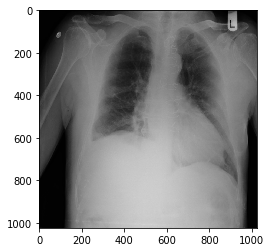

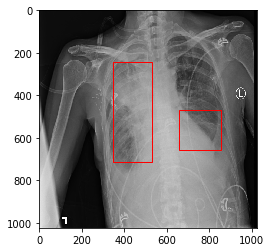

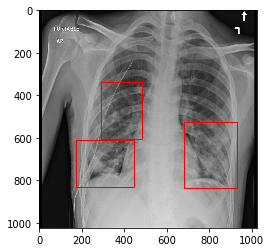

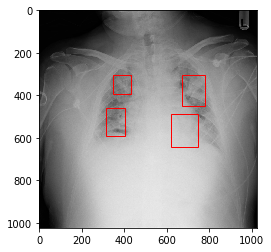

In [132]:
for i,ann in enumerate(annotations_for_plot):
    plot_with_box(ann[0]['patientId'], key='id')

Define the image augmentation process
--
In this Mask RCNN package, image augmentation should be defined with imagaug packages.

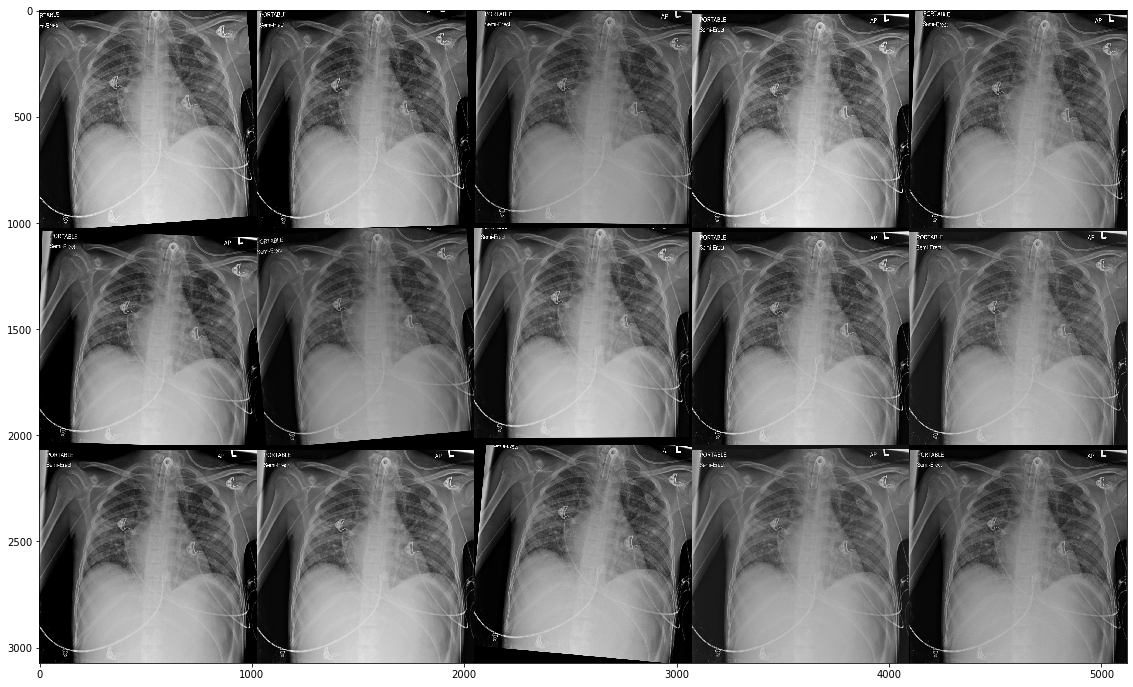

In [18]:
# This part refers to https://www.kaggle.com/hmendonca/mask-rcnn-with-submission
# Image augmentation (light but constant)

augmentation = imgaug.augmenters.Sequential([
#    imgaug.augmenters.imgaug.augmenters.Fliplr(0.5),
    imgaug.augmenters.OneOf([ ## geometric transform
        imgaug.augmenters.Affine(
            scale={"x": (0.98, 1.04), "y": (0.98, 1.04)},
            translate_percent={"x": (-0.03, 0.03), "y": (-0.05, 0.05)},
            rotate=(-5, 5),
            shear=(-3, 3),
        ),
        imgaug.augmenters.PiecewiseAffine(scale=(0.002, 0.03)),
    ]),
    imgaug.augmenters.OneOf([ ## brightness or contrast
        imgaug.augmenters.Multiply((0.85, 1.15)),
        imgaug.augmenters.contrast.LinearContrast((0.85, 1.15)),
    ]),
    imgaug.augmenters.OneOf([ ## blur or sharpen
        imgaug.augmenters.GaussianBlur(sigma=(0.0, 0.12)),
        imgaug.augmenters.Sharpen(alpha=(0.0, 0.12)),
    ]),
])

# test on the same image as above
patientId = 'ad7bfead-6c0b-436f-9d0b-92827be703c3'
ds = pydicom.read_file(train_dir+'/'+ patientId +'.dcm')
image = ds.pixel_array
#fig,ax = plt.subplots(1)
if len(image.shape) != 3 or image.shape[2] != 3:
    image = np.stack((image,) * 3, -1)

imggrid = augmentation.draw_grid(image[:, :, 0], cols=5, rows=3)
plt.figure(figsize=(30, 12))
plt.imshow(imggrid[:, :, 0], cmap='gray')

MASK RCNN model
--
The mask rcnn model we use are based on the implementation by Matterport Inc
https://github.com/matterport/Mask_RCNN

This post explains how the model works and how to use it in a real application very well:
https://engineering.matterport.com/splash-of-color-instance-segmentation-with-mask-r-cnn-and-tensorflow-7c761e238b46

Follow the "Code Tip":
Create the classes:
1. PneumoniaDataset class: the subclass of utils.Dataset. This class build up the dataset which the related functions used in the following process.
2. PneumoniaConfig class: the subclass of Config. This is the configuration of the training process.
3. InferenceConfig class: the subclass of Config. This is the configuration of the prediction process.

In [19]:
class PneumoniaDataset(utils.Dataset):
    def load_pneumonia(self, images_path, image_annotations):
        """Load a subset of the Pneumonia dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes. We have only one class to add.
        self.add_class("pneumonia", 1, "pneumonia")
        # Add images
        for i,img_path in enumerate(images_path):
            ds = pydicom.read_file(img_path)
            image_width = ds.data_element('Columns').value
            image_height = ds.data_element('Rows').value
            annotations = image_annotations[img_path]
            # the arguments in add_image will be updated to self.image_info
            self.add_image(source='pneumonia', image_id=i, path=img_path, image_width = image_width, image_height=image_height, annotations=annotations )

    def load_image(self, image_id):
        image_info = self.image_info[image_id]
        ds = pydicom.read_file(image_info['path'])
        image = ds.pixel_array
        # If grayscale. Convert to RGB for consistency.
        if len(image.shape) != 3 or image.shape[2] != 3:
            image = np.stack((image,) * 3, -1)
        return image            
            
    # load_mask is copied from matterport's baloon example
    def load_mask(self, image_id):
        """Generate instance masks for an image.
           Returns:
           masks: A bool array of shape [height, width, instance count] with
                  one mask per instance.
           class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a pneumonia dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "pneumonia":
            return super(self.__class__, self).load_mask(image_id)

        # Convert annotations to the mask of shape
        # [height, width, instance_count]
        annotations = image_info['annotations']
        n_mask = len(annotations) if len(annotations)>0 else 1 
        mask = np.zeros((image_info['image_height'], image_info['image_width'], n_mask), dtype=np.uint8)
        class_ids = np.zeros((n_mask,), dtype=np.int32)
        for i,a in enumerate(annotations):
            target = a['Target']
            if target != 0:
                x, y, width, height = [int(a[col]) for col in ['x','y','width','height'] ]
                mask_instance = mask[:, :, i].copy()
                # Get indexes of pixels inside the mask and set them to 1
                cv2.rectangle(mask_instance, (x, y), (x+width, y+height), 1, -1)
                mask[:, :, i] = mask_instance
                class_ids[i] = target
                                    
        # Return mask, and array of class IDs of each instance.                            
        return mask.astype(np.bool), class_ids

    def image_reference(self, image_id):
        """Return the path of the image."""
        image_info = self.image_info[image_id]
        if image_info["source"] == "pneumonia":
            return image_info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

In [51]:
class PneumoniaConfig(Config):
    # Give the configuration a recognizable name
    NAME = "Pneumonia"
    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # Background + Pneumonia
    # Number of training steps per epoch
    STEPS_PER_EPOCH = 1000
    # NUMBER OF GPUs to use. When using only a CPU, this needs to be set to 1.
    GPU_COUNT = 1
    IMAGES_PER_GPU = 4
    # "resnet101" or "resnet50"
    BACKBONE = "resnet50"
    # IMAGE_RESIZE_MODE = "square", "none", "pad64", "crop"
    IMAGE_RESIZE_MODE = "square"
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512
    RPN_ANCHOR_SCALES = (32, 64, 128, 256)
    # Number of ROIs per image to feed to classifier/mask heads
    # The Mask RCNN paper uses 512 but often the RPN doesn't generate
    # enough positive proposals to fill this and keep a positive:negative
    # ratio of 1:3. You can increase the number of proposals by adjusting
    # the RPN NMS threshold.
    TRAIN_ROIS_PER_IMAGE = 200
    LEARNING_RATE = 0.002

    # Percent of positive ROIs used to train classifier/mask heads
    ROI_POSITIVE_RATIO = 0.33 
    # Maximum number of ground truth instances to use in one image
    MAX_GT_INSTANCES = 4
    # Max number of final detections
    DETECTION_MAX_INSTANCES = 4
    
    LOSS_WEIGHTS = {
        "rpn_class_loss": 1.,
        "rpn_bbox_loss": 1.,
        "mrcnn_class_loss": 1.,
        "mrcnn_bbox_loss": 1.,
        "mrcnn_mask_loss": 0.
    }

In [52]:
config = PneumoniaConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     4
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        4
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 4
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.002
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 0.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                

In [53]:
class InferenceConfig(PneumoniaConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

In [23]:
# split the original training dataset into training and validation dataset 
image_train, image_val = train_test_split(image_list,test_size=0.2)

In [38]:
dataset_train = PneumoniaDataset()
dataset_train.load_pneumonia( image_train, image_annotations)
#dataset_train.load_pneumonia(args.dataset, "train")
dataset_train.prepare()
dataset_val = PneumoniaDataset()
dataset_val.load_pneumonia(image_val, image_annotations)
dataset_val.prepare()

Display a random image with bounding boxes

(1024, 1024, 3)
/home/ubuntu/ML_data/rsna_pneumonia_detection/DATA/stage_2_train_images/09147009-39a9-497a-ac10-a07cf7126d58.dcm
[1]


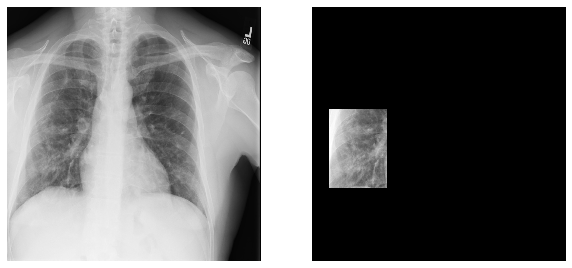

In [25]:
# Load and display random sample and their bounding boxes

class_ids = [0]
while class_ids[0] == 0:  ## look for a mask
    image_id = random.choice(dataset_train.image_ids)
    image_fp = dataset_train.image_reference(image_id)
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)

print(image.shape)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.axis('off')

plt.subplot(1, 2, 2)
masked = np.zeros(image.shape[:2])
for i in range(mask.shape[2]):
    masked += image[:, :, 0] * mask[:, :, i]
plt.imshow(masked, cmap='gray')
plt.axis('off')

print(image_fp)
print(class_ids)

In [61]:
# In the current state, weights must be "coco", "last", or "none"
def load_weights(model, Absolute_DIR, weights = "none"):
    if weights == "coco" :
        weights_path = os.path.join(Absolute_DIR, '..','pre-trained_weights','mask_rcnn_coco.h5')
        # Exclude the last layers because they require a matching
        # number of classes
        model.load_weights(weights_path, by_name=True, exclude=[
                    "mrcnn_class_logits", "mrcnn_bbox_fc",
                    "mrcnn_bbox", "mrcnn_mask"])
    elif weights == "last" :
        weights_path = model.find_last()
        model.load_weights(weights_path, by_name=True)
    elif weights == "none" :
        pass
    else:
        pass

Build and train the model
--
1. Build up the model architecture with the defined configuration.
2. Load the pre-trained weight from COCO database in order to use the transfer learning techniques.
3. DUring the training process, we first train the head architecture, and then more/all the layers

In [54]:
model = modellib.MaskRCNN(mode="training", config=config,
                                  model_dir=MODEL_DIR)
# weights must be "coco", "last", or "none"
load_weights(model, CURRENT_DIR, weights = "coco")

In [55]:
layers = []
epochs = []
learningrate = []

In [56]:
layers.append('heads')
epochs.append(25)
learningrate.append( config.LEARNING_RATE )
model.train(dataset_train, dataset_val,
            learning_rate=learningrate[-1],
            epochs=epochs[-1],
            layers=layers[-1],
            augmentation=augmentation)
history = model.keras_model.history.history


Starting at epoch 0. LR=0.002

Checkpoint Path: /home/ubuntu/ML_data/rsna_pneumonia_detection/MODEL_SAVE/pneumonia20200601T1427/mask_rcnn_pneumonia_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/ubuntu/anaconda3/envs/

Epoch 1/25
1000/1000 [==============================] - 892s 892ms/step - loss: 0.6974 - rpn_class_loss: 0.0212 - rpn_bbox_loss: 0.2868 - mrcnn_class_loss: 0.1014 - mrcnn_bbox_loss: 0.2880 - mrcnn_mask_loss: 0.0000e+00 - val_loss: 1.6480 - val_rpn_class_loss: 0.0559 - val_rpn_bbox_loss: 1.0417 - val_mrcnn_class_loss: 0.1405 - val_mrcnn_bbox_loss: 0.4098 - val_mrcnn_mask_loss: 0.0000e+00
Epoch 2/25
1000/1000 [==============================] - 835s 835ms/step - loss: 0.5255 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.2052 - mrcnn_class_loss: 0.0912 - mrcnn_bbox_loss: 0.2145 - mrcnn_mask_loss: 0.0000e+00 - val_loss: 1.2241 - val_rpn_class_loss: 0.0334 - val_rpn_bbox_loss: 0.6652 - val_mrcnn_class_loss: 0.0933 - val_mrcnn_bbox_loss: 0.4322 - val_mrcnn_mask_loss: 0.0000e+00
Epoch 3/25
1000/1000 [==============================] - 834s 834ms/step - loss: 0.4773 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 0.1872 - mrcnn_class_loss: 0.0831 - mrcnn_bbox_loss: 0.1942 - mrcnn_mask_loss: 0.0000e+00 -

Epoch 22/25
1000/1000 [==============================] - 835s 835ms/step - loss: 0.3425 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.1423 - mrcnn_class_loss: 0.0631 - mrcnn_bbox_loss: 0.1271 - mrcnn_mask_loss: 0.0000e+00 - val_loss: 1.1553 - val_rpn_class_loss: 0.0280 - val_rpn_bbox_loss: 0.5864 - val_mrcnn_class_loss: 0.1466 - val_mrcnn_bbox_loss: 0.3943 - val_mrcnn_mask_loss: 0.0000e+00
Epoch 23/25
1000/1000 [==============================] - 837s 837ms/step - loss: 0.3448 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.1473 - mrcnn_class_loss: 0.0586 - mrcnn_bbox_loss: 0.1290 - mrcnn_mask_loss: 0.0000e+00 - val_loss: 0.9213 - val_rpn_class_loss: 0.0091 - val_rpn_bbox_loss: 0.3396 - val_mrcnn_class_loss: 0.1804 - val_mrcnn_bbox_loss: 0.3922 - val_mrcnn_mask_loss: 0.0000e+00
Epoch 24/25
1000/1000 [==============================] - 833s 833ms/step - loss: 0.3406 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.1464 - mrcnn_class_loss: 0.0587 - mrcnn_bbox_loss: 0.1255 - mrcnn_mask_loss: 0.0000e+0

In [62]:
load_weights(model, CURRENT_DIR, weights = "last")

layers.append('5+')
epochs.append(40)
learningrate.append( config.LEARNING_RATE/10 )

model.train(dataset_train, dataset_val,
            learning_rate=learningrate[-1],
            epochs=epochs[-1],
            layers=layers[-1],
            augmentation=augmentation)
new_history = model.keras_model.history.history
for k in new_history: history[k] = history[k] + new_history[k]

Re-starting from epoch 25

Starting at epoch 25. LR=0.0002

Checkpoint Path: /home/ubuntu/ML_data/rsna_pneumonia_detection/MODEL_SAVE/pneumonia20200601T1427/mask_rcnn_pneumonia_{epoch:04d}.h5
Selecting layers to train
res5a_branch2a         (Conv2D)
bn5a_branch2a          (BatchNorm)
res5a_branch2b         (Conv2D)
bn5a_branch2b          (BatchNorm)
res5a_branch2c         (Conv2D)
res5a_branch1          (Conv2D)
bn5a_branch2c          (BatchNorm)
bn5a_branch1           (BatchNorm)
res5b_branch2a         (Conv2D)
bn5b_branch2a          (BatchNorm)
res5b_branch2b         (Conv2D)
bn5b_branch2b          (BatchNorm)
res5b_branch2c         (Conv2D)
bn5b_branch2c          (BatchNorm)
res5c_branch2a         (Conv2D)
bn5c_branch2a          (BatchNorm)
res5c_branch2b         (Conv2D)
bn5c_branch2b          (BatchNorm)
res5c_branch2c         (Conv2D)
bn5c_branch2c          (BatchNorm)
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2        

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/ubuntu/anaconda3/envs/

Epoch 26/40
1000/1000 [==============================] - 930s 930ms/step - loss: 0.7710 - rpn_class_loss: 0.0174 - rpn_bbox_loss: 0.3424 - mrcnn_class_loss: 0.1038 - mrcnn_bbox_loss: 0.3073 - mrcnn_mask_loss: 0.0000e+00 - val_loss: 1.7745 - val_rpn_class_loss: 0.0754 - val_rpn_bbox_loss: 1.1696 - val_mrcnn_class_loss: 0.1104 - val_mrcnn_bbox_loss: 0.4192 - val_mrcnn_mask_loss: 0.0000e+00
Epoch 27/40
1000/1000 [==============================] - 869s 869ms/step - loss: 0.7004 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.3080 - mrcnn_class_loss: 0.0960 - mrcnn_bbox_loss: 0.2811 - mrcnn_mask_loss: 0.0000e+00 - val_loss: 0.9946 - val_rpn_class_loss: 0.0297 - val_rpn_bbox_loss: 0.5582 - val_mrcnn_class_loss: 0.0695 - val_mrcnn_bbox_loss: 0.3372 - val_mrcnn_mask_loss: 0.0000e+00
Epoch 28/40
1000/1000 [==============================] - 871s 871ms/step - loss: 0.6337 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.2512 - mrcnn_class_loss: 0.0895 - mrcnn_bbox_loss: 0.2802 - mrcnn_mask_loss: 0.0000e+0

In [63]:
with open("record.dat","w+") as f:
    f.write(model.find_last())
    f.write("\n------------------")
    f.write('\nlayers:')
    f.write(layers)
    f.write('\nepochs:')
    f.write(epochs)
    f.write('\nlearningrate:')
    f.write(learningrate)
    f.write("\nConfigurations:")
    for a in dir(config):
        if not a.startswith("__") and not callable(getattr(config, a)):
            f.write("\n")
            f.write("{:30} {}".format(a, getattr(config, a)))
    f.write("\n")

TypeError: write() argument must be str, not list

**Make prediction**

In [64]:
inference_config = InferenceConfig()
model_inference = modellib.MaskRCNN(mode='inference', 
                                    config=inference_config,
                                    model_dir=MODEL_DIR)
weights_path = model.find_last()
print("Loading weights from ", weights_path)
model_inference.load_weights(weights_path, by_name=True)
#load_weights(model_inference, CURRENT_DIR, weights = "last")



Instructions for updating:
Use `tf.cast` instead.
Loading weights from  /home/ubuntu/ML_data/rsna_pneumonia_detection/MODEL_SAVE/pneumonia20200601T1427/mask_rcnn_pneumonia_0040.h5
Re-starting from epoch 40


How does the predicted box compared to the expected value?

In [134]:
def train_data_detect(patient_id):
    ds = pydicom.read_file(train_dir+'/'+ patient_id +'.dcm')
    image = ds.pixel_array
    if len(image.shape) != 3 or image.shape[2] != 3:
        image = np.stack((image,) * 3, -1)
    x, y, width, height, target = [list(train_label[ train_label['patientId']== patient_id][col]) for col in train_label.columns[1:6]]
    patient_id = os.path.splitext(os.path.basename(image_file))[0]
    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,20))
    for i in range(len(target)):
        if target[i] == 1:
            rect = patches.Rectangle((x[i],y[i]),width[i],height[i],linewidth=1,edgecolor='r',facecolor='none')
            ax1.add_patch(rect)
#            axes[0,0].add_patch(rect)
#    plt.imshow(image)
    ax1.imshow(image)
    
    result = model_inference.detect([image])
    num_box = len(result[0]['rois'])  # rois: [N, (y1, x1, y2, x2)] detection bounding boxes
    if( num_box != 0 ):
        for i in range(num_box):
            y1,x1,y2,x2 = result[0]['rois'][i] 
            box_width = x2 - x1
            box_height = y2 - y1
            rect = patches.Rectangle((x1,y1),box_width,box_height,linewidth=1,edgecolor='r',facecolor='none')
            ax2.add_patch(rect)
#            axes[0,1].add_patch(rect)
#    plt.imshow(image)
    ax2.imshow(image)
    plt.show()

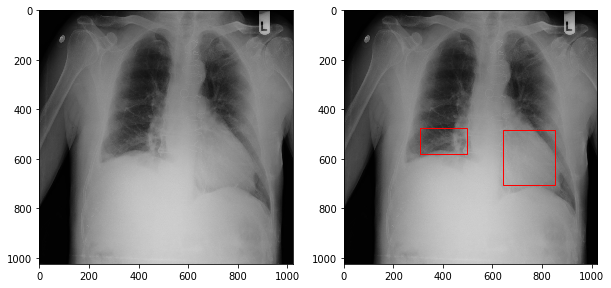

In [138]:
train_data_detect('c665b581-f134-41a6-967d-53471fb97f06')

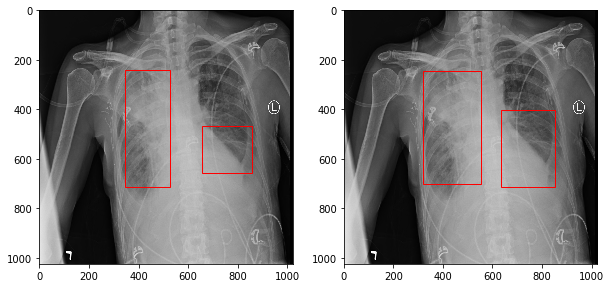

In [135]:
train_data_detect('ba54e255-4d76-4f33-ab14-cbe9ac42c5a5')

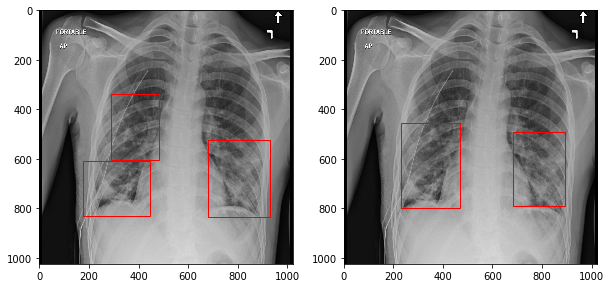

In [136]:
train_data_detect('8a233483-8ab2-4cc5-b32b-20fe40cc5d77')

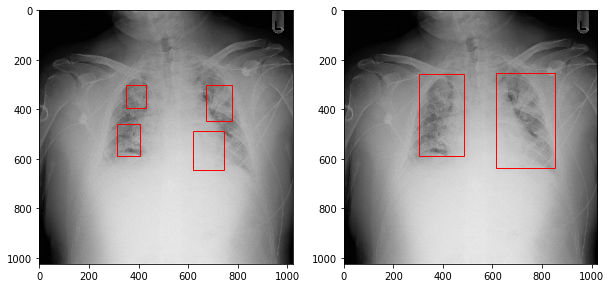

In [137]:
train_data_detect('76f71a93-8105-4c79-a010-0cfa86f0061a')

In [139]:
#submit_dict = {"patientId": [], "PredictionString": []}
submit_table = pd.DataFrame(columns=['patientId','PredictionString'])
test_image_list = files_to_list( test_dir )
for image_file in test_image_list:
    ds = pydicom.read_file(image_file)
    image = ds.pixel_array
    # If grayscale. Convert to RGB for consistency.
    if len(image.shape) != 3 or image.shape[2] != 3:
        image = np.stack((image,) * 3, -1)
#    resize_height = ds.data_element('Rows').value / config.IMAGE_SHAPE[0]
#    resize_width  = ds.data_element('Columns').value / config.IMAGE_SHAPE[1]
    patient_id = os.path.splitext(os.path.basename(image_file))[0]
    result = model_inference.detect([image])
    num_box = len(result[0]['rois'])  # rois: [N, (y1, x1, y2, x2)] detection bounding boxes
    bboxes_strs = ''
    if num_box != 0:
        for i in range(num_box):
            confidence = round(result[0]['scores'][i], 2)
            if (confidence >= 0.7):
                confidence = str(confidence)
                y1,x1,y2,x2 = result[0]['rois'][i] 
                box_width = x2 - x1
                box_height = y2 - y1
                bboxes_str = "{} {} {} {} {} {}".format(confidence, x1, y1, box_width, box_height, ' ')
                bboxes_strs += bboxes_str
    submit_table = submit_table.append({ 'patientId': patient_id, 'PredictionString':bboxes_strs }, ignore_index=True)        

In [140]:
# get the file to be submitted
submit_table.to_csv('submission.csv', index=False)

In [106]:
submit_table.head(60)

,patientId,PredictionString
0,032463f7-34e0-4bf3-906a-09e5e2956882,0.97 683 493 214 232 0.92 348 409 221 232
1,13c7e896-0bae-43eb-8e9a-f498e3defff4,0.96 498 369 119 165 0.94 231 436 161 107 0....
2,1f18d832-13b9-40e9-9797-a6433c742296,0.99 236 472 198 208 0.81 227 286 147 136
3,04892909-51b5-475c-9234-e7e97fb77c83,0.94 588 312 251 166 0.82 243 272 170 185
4,13c01189-82f2-4567-98c5-f0fb9ac3c80d,0.97 340 329 149 256 0.94 632 418 129 168
5,306da180-4249-4659-9ea6-1c2ed1455668,1.0 599 472 240 224
6,c0957a54-79af-4505-a5de-c49c52e7c959,0.99 595 347 267 236 0.93 177 308 186 143 0....
7,2badcdd6-4733-47ae-bdfc-412bb853e9a1,0.98 644 507 227 235 0.95 292 405 140 95 0.9...
8,04d35c6d-2ff0-4e0b-be77-d477f99bc825,0.99 229 421 192 326 0.89 606 524 213 269
9,0050f8bb-36a4-4a1a-8de5-2d73154c2571,0.97 607 512 169 186 0.91 292 475 139 200 0....
